#### Reference
* https://www.kaggle.com/gpreda/santander-eda-and-prediction
* https://www.kaggle.com/roydatascience/eda-pca-simple-lgbm-on-kfold-technique

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/santander-customer-transaction-prediction/sample_submission.csv
/kaggle/input/santander-customer-transaction-prediction/train.csv
/kaggle/input/santander-customer-transaction-prediction/test.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import plotly.express as px


from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
import lightgbm as lgb
from lightgbm import plot_importance
import xgboost as xgb



plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
train_df = pd.read_csv('/kaggle/input/santander-customer-transaction-prediction/train.csv')
test_df = pd.read_csv('/kaggle/input/santander-customer-transaction-prediction/test.csv')
train_df.head()

ID_code  target    var_0   var_1    var_2   var_3    var_4   var_5   var_6  \
0  train_0       0   8.9255 -6.7863  11.9081  5.0930  11.4607 -9.2834  5.1187   
1  train_1       0  11.5006 -4.1473  13.8588  5.3890  12.3622  7.0433  5.6208   
2  train_2       0   8.6093 -2.7457  12.0805  7.8928  10.5825 -9.0837  6.9427   
3  train_3       0  11.0604 -2.1518   8.9522  7.1957  12.5846 -1.8361  5.8428   
4  train_4       0   9.8369 -1.4834  12.8746  6.6375  12.2772  2.4486  5.9405   

     var_7  ...  var_190  var_191  var_192  var_193  var_194  var_195  \
0  18.6266  ...   4.4354   3.9642   3.1364   1.6910  18.5227  -2.3978   
1  16.5338  ...   7.6421   7.7214   2.5837  10.9516  15.4305   2.0339   
2  14.6155  ...   2.9057   9.7905   1.6704   1.6858  21.6042   3.1417   
3  14.9250  ...   4.4666   4.7433   0.7178   1.4214  23.0347  -1.2706   
4  19.2514  ...  -1.4905   9.5214  -0.1508   9.1942  13.2876  -1.5121   

   var_196  var_197  var_198  var_199  
0   7.8784   8.5635  12.7803  -1.0914  
1   8.1267   8.7889  18.3560   1.9518  
2  -6.5213   8.2675  14.7222   0.3965  
3  -2.9275  10.2922  17.9697  -8.9996  
4   3.9267   9.5031  17.9974  -8.8104  

[5 rows x 202 columns]

In [4]:
features = train_df.drop(['ID_code','target'],axis=1)

In [5]:
train_df.shape

(200000, 202)

# EDA
* Target Percent

In [6]:
train_df['target'].value_counts()

0    179902
1     20098
Name: target, dtype: int64

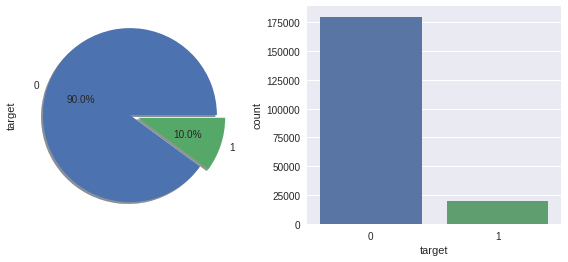

In [7]:
f, ax = plt.subplots(1,2,figsize=(10,4))
train_df['target'].value_counts().plot.pie(
    explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True
)
sns.countplot('target', data=train_df, ax=ax[1])
plt.show()

In [8]:
null_value = train_df.isnull().sum().sort_values(ascending = False)
null_percent = round(train_df.isnull().sum().sort_values(ascending = False)/len(train_df)*100, 2)
pd.concat([null_value,null_percent], axis=1,keys=['Null values','Percent'])

Null values  Percent
var_199            0      0.0
var_61             0      0.0
var_71             0      0.0
var_70             0      0.0
var_69             0      0.0
...              ...      ...
var_129            0      0.0
var_128            0      0.0
var_127            0      0.0
var_126            0      0.0
ID_code            0      0.0

[202 rows x 2 columns]

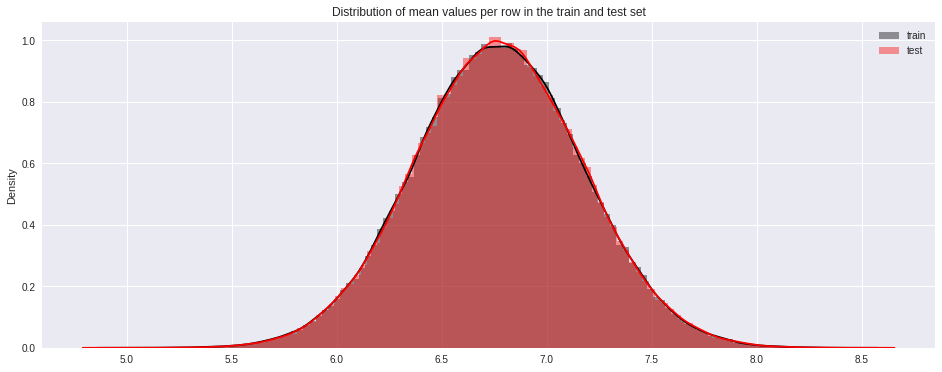

In [9]:
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per row in the train and test set")
sns.distplot(train_df[features.columns].mean(axis=1),color="black", kde=True,bins=120, label='train')
sns.distplot(test_df[features.columns].mean(axis=1),color="red", kde=True,bins=120, label='test')
plt.legend()
plt.show()

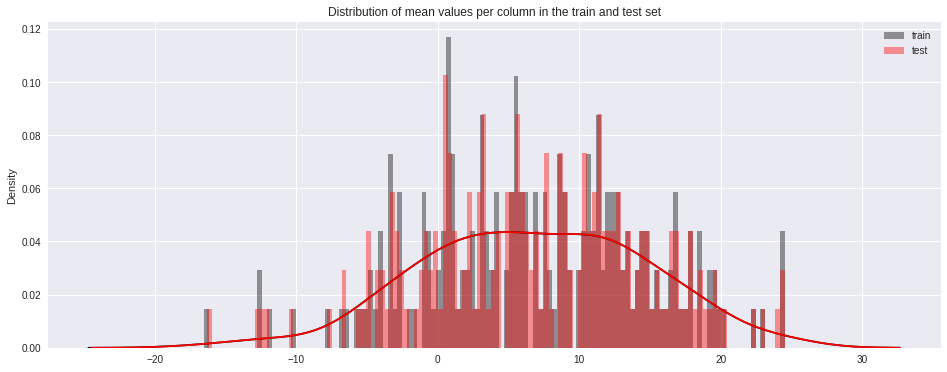

In [10]:
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per column in the train and test set")
sns.distplot(train_df[features.columns].mean(),color="black", kde=True,bins=120, label='train')
sns.distplot(test_df[features.columns].mean(),color="red", kde=True,bins=120, label='test')
plt.legend()
plt.show()

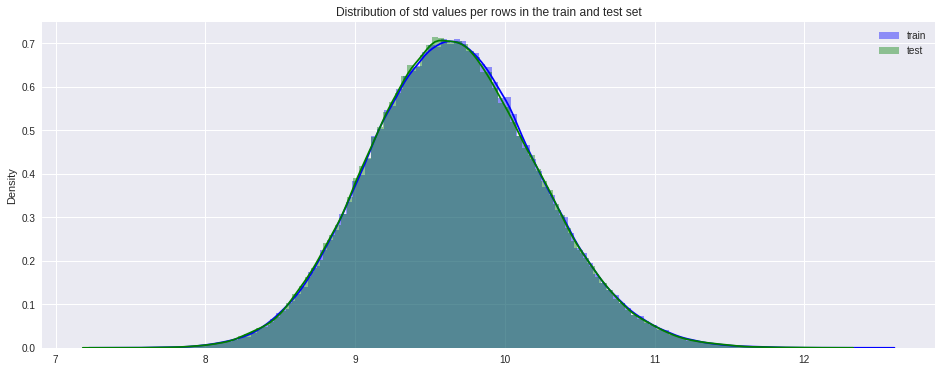

In [11]:
plt.figure(figsize=(16,6))
plt.title("Distribution of std values per rows in the train and test set")
sns.distplot(train_df[features.columns].std(axis=1),color="blue",kde=True,bins=120, label='train')
sns.distplot(test_df[features.columns].std(axis=1),color="green", kde=True,bins=120, label='test')
plt.legend(); plt.show()

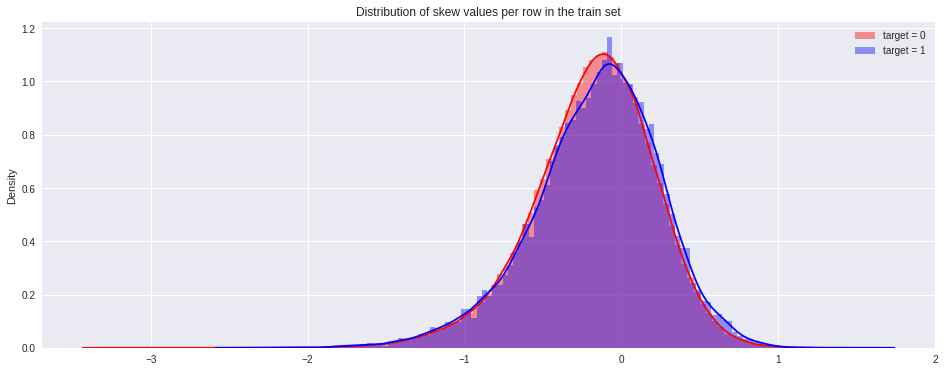

In [12]:
t0 = train_df[train_df['target'] == 0]
t1 = train_df[train_df['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of skew values per row in the train set")
sns.distplot(t0[features.columns].skew(axis=1),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features.columns].skew(axis=1),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

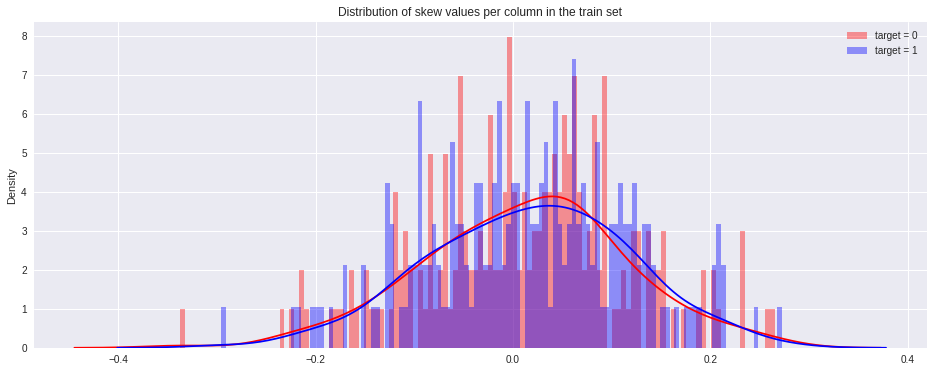

In [13]:
t0 = train_df[train_df['target'] == 0]
t1 = train_df[train_df['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of skew values per column in the train set")
sns.distplot(t0[features.columns].skew(),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features.columns].skew(),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

# Preprocessing
* Drop Columns

In [14]:
train_df.drop('ID_code', axis=1, inplace=True)
test_df.drop('ID_code', axis=1, inplace=True)

In [15]:
train_df.head()

target    var_0   var_1    var_2   var_3    var_4   var_5   var_6    var_7  \
0       0   8.9255 -6.7863  11.9081  5.0930  11.4607 -9.2834  5.1187  18.6266   
1       0  11.5006 -4.1473  13.8588  5.3890  12.3622  7.0433  5.6208  16.5338   
2       0   8.6093 -2.7457  12.0805  7.8928  10.5825 -9.0837  6.9427  14.6155   
3       0  11.0604 -2.1518   8.9522  7.1957  12.5846 -1.8361  5.8428  14.9250   
4       0   9.8369 -1.4834  12.8746  6.6375  12.2772  2.4486  5.9405  19.2514   

    var_8  ...  var_190  var_191  var_192  var_193  var_194  var_195  var_196  \
0 -4.9200  ...   4.4354   3.9642   3.1364   1.6910  18.5227  -2.3978   7.8784   
1  3.1468  ...   7.6421   7.7214   2.5837  10.9516  15.4305   2.0339   8.1267   
2 -4.9193  ...   2.9057   9.7905   1.6704   1.6858  21.6042   3.1417  -6.5213   
3 -5.8609  ...   4.4666   4.7433   0.7178   1.4214  23.0347  -1.2706  -2.9275   
4  6.2654  ...  -1.4905   9.5214  -0.1508   9.1942  13.2876  -1.5121   3.9267   

   var_197  var_198  var_199  
0   8.5635  12.7803  -1.0914  
1   8.7889  18.3560   1.9518  
2   8.2675  14.7222   0.3965  
3  10.2922  17.9697  -8.9996  
4   9.5031  17.9974  -8.8104  

[5 rows x 201 columns]

# Feature Egineering
* PCA
* Split Data to Train / Test / Validation

In [16]:
x = train_df.drop(['target'], axis=1,)
y = train_df['target']

In [17]:
scaler = StandardScaler()
x_scaler = scaler.fit_transform(x)
x_scaler_df = pd.DataFrame(x_scaler, columns=x.columns)

pca = PCA(n_components=2)
x_scaler_pca = pca.fit_transform(x_scaler)
x_scaler_pca_df = pd.DataFrame(x_scaler_pca)

In [18]:
test_scaler = StandardScaler()
trans_test_scaler = test_scaler.fit_transform(test_df)
trans_test_scaler_df = pd.DataFrame(trans_test_scaler, columns=test_df.columns)

In [19]:
x_scaler_pca_df.head()

0         1
0 -0.382564 -0.875979
1  2.571330 -0.864943
2  0.476888 -0.095190
3  0.435534 -0.357897
4  0.066788 -0.353916

In [20]:
pca.explained_variance_ratio_

array([0.00553388, 0.00511613])

In [21]:
sum(pca.explained_variance_ratio_)

0.010650011738440837

In [22]:
x_scaler_pca_df['target'] = y

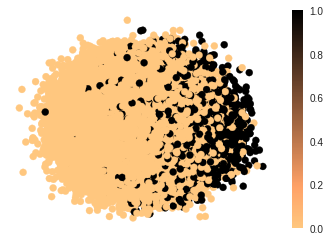

In [23]:
plt.scatter(x_scaler_pca_df.loc[:, 0], x_scaler_pca_df.loc[:, 1], c=y,  cmap="copper_r")
plt.axis('off')
plt.colorbar()
plt.show()

=> We cant use PCA

In [24]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [25]:
print("Train Dataset shape {} / {}".format(x_train.shape, y_train.shape))
print("Test Dataset shape {} / {}".format(x_test.shape, y_test.shape))

Train Dataset shape (160000, 200) / (160000,)
Test Dataset shape (40000, 200) / (40000,)


# Modeling
* LightGBM

In [26]:
train_data = lgb.Dataset(x_train, label=y_train)
val_data = lgb.Dataset(x_test, label=y_test)
params = {
    'n_estimators': 5000,
    'num_leaves': 20,
    'max_depth': -1,
    'min_data_in_leaf': 80,
    'learning_rate': 0.01,
    'boosting': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'Is_training_metric': True,
    'n_jobs': -1
}

In [27]:
model = lgb.train(params,
                  train_data,
                  valid_sets=val_data, 
                  valid_names=['train','valid'],
                  early_stopping_rounds=100)

[LightGBM] [Warning] Unknown parameter: Is_training_metric
[LightGBM] [Warning] Unknown parameter: Is_training_metric
[LightGBM] [Info] Number of positive: 16084, number of negative: 143916
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.580933 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51000
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 200
[LightGBM] [Warning] Unknown parameter: Is_training_metric
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.100525 -> initscore=-2.191405
[LightGBM] [Info] Start training from score -2.191405
[1]	train's auc: 0.647738
Training until validation scores don't improve for 100 rounds
[2]	train's auc: 0.659109
[3]	train's auc: 0.665783
[4]	train's auc: 0.665389
[5]	train's auc: 0.669834
[6]	train's auc: 0.675501
[7]	train's auc: 0.676166
[8]	train's auc: 0.678748
[9]	train's auc: 0.68043
[10]	train's auc: 0.681152


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

<Figure size 720x720 with 0 Axes>

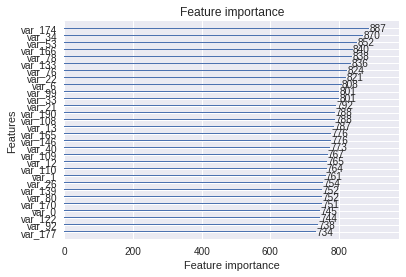

In [28]:
plt.figure(figsize=(10,10))
plot_importance(model, max_num_features=30)

* StandardScaler

In [29]:
x_train, x_test, y_train, y_test = train_test_split(x_scaler_df, y, test_size=0.2)

In [30]:
train_data = lgb.Dataset(x_train, label=y_train)
val_data = lgb.Dataset(x_test, label=y_test)
params = {
    'n_estimators': 5000,
    'num_leaves': 20,
    'max_depth': -1,
    'min_data_in_leaf': 80,
    'learning_rate': 0.01,
    'boosting': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'Is_training_metric': True,
    'n_jobs': -1
}

In [31]:
scaler_model = lgb.train(params,
                  train_data,
                  valid_sets=val_data, 
                  valid_names=['train','valid'],
                  early_stopping_rounds=100)

[LightGBM] [Warning] Unknown parameter: Is_training_metric
[LightGBM] [Warning] Unknown parameter: Is_training_metric
[LightGBM] [Info] Number of positive: 16098, number of negative: 143902
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.417166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51000
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 200
[LightGBM] [Warning] Unknown parameter: Is_training_metric
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.100612 -> initscore=-2.190437
[LightGBM] [Info] Start training from score -2.190437
[1]	train's auc: 0.656478
Training until validation scores don't improve for 100 rounds
[2]	train's auc: 0.661106
[3]	train's auc: 0.668072
[4]	train's auc: 0.669797
[5]	train's auc: 0.671214
[6]	train's auc: 0.67727
[7]	train's auc: 0.680769
[8]	train's auc: 0.683316
[9]	train's auc: 0.686117
[10]	train's auc: 0.68706
[

# Submission

In [32]:
submission = pd.read_csv('/kaggle/input/santander-customer-transaction-prediction/sample_submission.csv')
submission.head()

ID_code  target
0  test_0       0
1  test_1       0
2  test_2       0
3  test_3       0
4  test_4       0

In [33]:
target = model.predict(test_df)

In [34]:
submission['target'] = target

In [35]:
submission.head()

ID_code    target
0  test_0  0.058403
1  test_1  0.217373
2  test_2  0.288196
3  test_3  0.123030
4  test_4  0.044472

In [36]:
submission.to_csv('submission.csv', index=False)

In [37]:
scaler_submission = pd.read_csv('/kaggle/input/santander-customer-transaction-prediction/sample_submission.csv')
scaler_submission.head()

ID_code  target
0  test_0       0
1  test_1       0
2  test_2       0
3  test_3       0
4  test_4       0

In [38]:
scaler_target = scaler_model.predict(trans_test_scaler_df)

In [39]:
scaler_submission['target'] = scaler_target

In [40]:
scaler_submission.to_csv('scaler_submission.csv', index=False)